<a href="https://colab.research.google.com/github/dmsroysillerico/MAE_M13_PUB/blob/main/Sprint2D_Churn_Olist_DRIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sprint2D – Churn de Clientes Olist (Sprint 1 + Sprint 2 + Pipeline Mensual)

Notebook unificado para el proyecto de **Análisis de Churn** usando el dataset de Olist.

Integra:

- **Sprint 1**: problema de negocio, EDA, hipótesis, definición de target preliminar y métricas base.  
- **Sprint 2**: pipeline reproducible, data cleaning, creación de features (100+), KPI finales, target final, modelos y selección de variables.  
- Simulación de **incorporación mensual de nuevos datos** mediante una **fecha de corte por período (YYYY-MM)** y persistencia de resultados (snapshots mensuales en Parquet + histórico de KPIs).



## Índice

1. Introducción, problema de negocio y objetivo del MVP  
2. Configuración del entorno e imports  
3. Montaje de Google Drive (Colab) y rutas de datos  
4. Carga de datos Olist y tablas base  
5. EDA inicial (Sprint 1)  
6. Parámetros del pipeline mensual  
7. Funciones del pipeline (limpieza, recorte, master de órdenes)  
8. Master table por cliente y Feature Engineering (100+ features)  
9. Definición de target de churn (preliminar y final) + KPIs  
10. Preparación de datos y selección de variables  
11. Modelos (Logistic Regression y Random Forest)  
12. Métricas de negocio y pruebas Chi² / ANOVA  
13. Función `run_monthly_pipeline()` y persistencia de snapshots  
14. Notas para Git y storytelling  



## 1. Introducción, problema de negocio y objetivo del MVP

- **Negocio**: Marketplace Olist (Brasil), donde múltiples sellers venden a clientes finales.  
- **Problema**: identificar **clientes con riesgo de abandono (churn)** para priorizar acciones de retención.  
- **Unidad de análisis**: cliente final (`customer_unique_id`).  
- **Churn (definición operativa)**: cliente que **compró en el pasado** pero lleva tantos días sin comprar que, desde el punto de vista del negocio, se considera **inactivo/perdido**.  
- **Periodicidad**: el negocio evalúa churn de forma **mensual**, con cortes a fin de mes.

**Objetivo del MVP**

Construir un pipeline que, para un **período objetivo (YYYY-MM)**:

1. Reciba los datos transaccionales de Olist y los recorte hasta una **fecha de corte** (último día del mes).  
2. Genere una **master table por cliente** con más de **100 features** (RFM, valor económico, logística, reviews, etc.).  
3. Defina un **target de churn** (preliminar y final) basado en la recencia de compra.  
4. Entrene al menos **dos modelos de clasificación** (baseline + modelo más robusto) priorizando **recall** sobre clientes churn.  
5. Calcule **KPIs de negocio** (churn rate, retención, gasto promedio, etc.) y los persista como snapshots mensuales.


## 2. Configuración del entorno e imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.4f}".format

print("Entorno listo.")


Entorno listo.


## 3. Montaje de Google Drive (Colab) y rutas de datos

In [2]:

    from google.colab import drive
    drive.mount('/content/drive')

    DATA_DIR = Path('/content/drive/MyDrive/Maestria/M13/Olist')

    print("Archivos encontrados para análisis:")
    for f in DATA_DIR.glob('*.csv'):
        print(" -", f.name)

    PROCESSED_DIR = DATA_DIR / 'processed'
    (PROCESSED_DIR / 'master').mkdir(parents=True, exist_ok=True)
    (PROCESSED_DIR / 'features').mkdir(parents=True, exist_ok=True)
    (PROCESSED_DIR / 'metrics').mkdir(parents=True, exist_ok=True)

    print("\nCarpetas de salida listas:")
    print(" -", PROCESSED_DIR / 'master')
    print(" -", PROCESSED_DIR / 'features')
    print(" -", PROCESSED_DIR / 'metrics')


Mounted at /content/drive
Archivos encontrados para análisis:
 - olist_customers_dataset.csv
 - olist_geolocation_dataset.csv
 - olist_order_items_dataset.csv
 - olist_order_payments_dataset.csv
 - olist_orders_dataset.csv
 - olist_order_reviews_dataset.csv
 - olist_products_dataset.csv
 - olist_sellers_dataset.csv
 - product_category_name_translation.csv

Carpetas de salida listas:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics


## 4. Carga de datos Olist y tablas base

In [3]:

def load_olist_data(data_dir: Path) -> dict:
    """Carga los CSV de Olist y devuelve un diccionario de DataFrames."""

    orders = pd.read_csv(
        data_dir / 'olist_orders_dataset.csv',
        parse_dates=[
            'order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date'
        ]
    )
    customers = pd.read_csv(data_dir / 'olist_customers_dataset.csv')
    order_items = pd.read_csv(
        data_dir / 'olist_order_items_dataset.csv',
        parse_dates=['shipping_limit_date']
    )
    order_payments = pd.read_csv(data_dir / 'olist_order_payments_dataset.csv')
    order_reviews = pd.read_csv(
        data_dir / 'olist_order_reviews_dataset.csv',
        parse_dates=['review_creation_date', 'review_answer_timestamp']
    )
    products = pd.read_csv(data_dir / 'olist_products_dataset.csv')
    sellers = pd.read_csv(data_dir / 'olist_sellers_dataset.csv')
    geolocation = pd.read_csv(data_dir / 'olist_geolocation_dataset.csv')
    prod_cat_trans = pd.read_csv(data_dir / 'product_category_name_translation.csv')

    return {
        'orders': orders,
        'customers': customers,
        'order_items': order_items,
        'order_payments': order_payments,
        'order_reviews': order_reviews,
        'products': products,
        'sellers': sellers,
        'geolocation': geolocation,
        'prod_cat_trans': prod_cat_trans
    }

data = load_olist_data(DATA_DIR)

print("Tablas cargadas:\n")
for name, df in data.items():
    print(f"{name:15s}: {df.shape[0]:7d} filas x {df.shape[1]:2d} columnas")


Tablas cargadas:

orders         :   99441 filas x  8 columnas
customers      :   99441 filas x  5 columnas
order_items    :  112650 filas x  7 columnas
order_payments :  103886 filas x  5 columnas
order_reviews  :   99224 filas x  7 columnas
products       :   32951 filas x  9 columnas
sellers        :    3095 filas x  4 columnas
geolocation    : 1000163 filas x  5 columnas
prod_cat_trans :      71 filas x  2 columnas


## 5. EDA inicial (Sprint 1)

Rango temporal de `order_purchase_timestamp`:
  Mínimo: 2016-09-04 21:15:19
  Máximo: 2018-10-17 17:30:18
  Duración (días): 772

Número de pedidos y clientes:
  Pedidos totales: 99441
  Clientes (customer_id) únicos: 99441
  Clientes (customer_unique_id) únicos: 96096

Valores faltantes en orders:


,missing_count,missing_pct
order_delivered_customer_date,2965,2.9817
order_delivered_carrier_date,1783,1.7930
order_approved_at,160,0.1609



Distribución de `order_status`:


,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


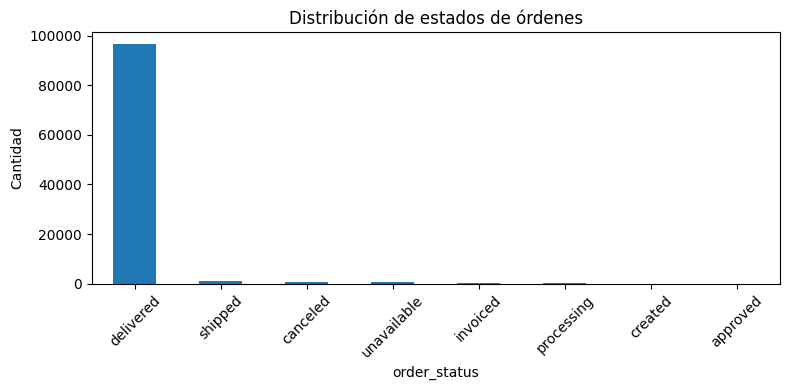

In [4]:

orders = data['orders']
customers = data['customers']

print("Rango temporal de `order_purchase_timestamp`:")
print("  Mínimo:", orders['order_purchase_timestamp'].min())
print("  Máximo:", orders['order_purchase_timestamp'].max())
print("  Duración (días):",
      (orders['order_purchase_timestamp'].max() - orders['order_purchase_timestamp'].min()).days)

print("\nNúmero de pedidos y clientes:")
print("  Pedidos totales:", len(orders))
print("  Clientes (customer_id) únicos:", orders['customer_id'].nunique())
print("  Clientes (customer_unique_id) únicos:", customers['customer_unique_id'].nunique())

def missing_values_table(df: pd.DataFrame, max_rows: int = 20):
    mv = df.isna().sum()
    mv = mv[mv > 0].sort_values(ascending=False)
    res = pd.DataFrame({
        'missing_count': mv,
        'missing_pct': mv / len(df) * 100
    })
    return res.head(max_rows)

print("\nValores faltantes en orders:")
display(missing_values_table(orders))

status_counts = orders['order_status'].value_counts().sort_values(ascending=False)
print("\nDistribución de `order_status`:")
display(status_counts)

plt.figure(figsize=(8, 4))
status_counts.plot(kind='bar')
plt.title('Distribución de estados de órdenes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Parámetros del pipeline mensual

In [5]:

PERIODO_OBJETIVO = "2018-06"  # YYYY-MM

periodo = pd.Period(PERIODO_OBJETIVO, freq='M')
FECHA_CORTE = periodo.to_timestamp('M')

print(f"PERIODO_OBJETIVO: {PERIODO_OBJETIVO}")
print(f"FECHA_CORTE: {FECHA_CORTE}")


PERIODO_OBJETIVO: 2018-06
FECHA_CORTE: 2018-06-30 00:00:00


## 7. Funciones del pipeline (limpieza, recorte, master de órdenes)

In [6]:

def clean_orders(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[~df['order_purchase_timestamp'].isna()]
    return df

def clean_customers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.drop_duplicates(subset=['customer_id'])
    return df

def clean_order_items(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def clean_order_payments(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def clean_order_reviews(df: pd.DataFrame) -> pd.DataFrame:
    return df.copy()

def get_last_processed_period(features_dir: Path):
    pattern = 'customer_features_'
    files = list(features_dir.glob(f'{pattern}*.parquet'))
    if not files:
        return None
    periods = []
    for f in files:
        name = f.stem
        if pattern in name:
            periods.append(name.replace(pattern, ''))
    return max(periods) if periods else None

last_period = get_last_processed_period(PROCESSED_DIR / 'features')
print("Último período procesado encontrado:", last_period)

def cut_data_to_fecha_corte(data_dict: dict, fecha_corte: pd.Timestamp) -> dict:
    orders_all = clean_orders(data_dict['orders'])
    customers_all = clean_customers(data_dict['customers'])
    order_items_all = clean_order_items(data_dict['order_items'])
    order_payments_all = clean_order_payments(data_dict['order_payments'])
    order_reviews_all = clean_order_reviews(data_dict['order_reviews'])

    orders_cut = orders_all[orders_all['order_purchase_timestamp'] <= fecha_corte].copy()

    order_ids = orders_cut['order_id'].unique()
    customer_ids = orders_cut['customer_id'].unique()

    order_items_cut = order_items_all[order_items_all['order_id'].isin(order_ids)].copy()
    order_payments_cut = order_payments_all[order_payments_all['order_id'].isin(order_ids)].copy()
    order_reviews_cut = order_reviews_all[order_reviews_all['order_id'].isin(order_ids)].copy()
    customers_cut = customers_all[customers_all['customer_id'].isin(customer_ids)].copy()

    return {
        'orders': orders_cut,
        'customers': customers_cut,
        'order_items': order_items_cut,
        'order_payments': order_payments_cut,
        'order_reviews': order_reviews_cut
    }

data_cut = cut_data_to_fecha_corte(data, FECHA_CORTE)

print("Tamaños después de FECHA_CORTE:")
for name, df in data_cut.items():
    print(f"{name:15s}: {df.shape[0]:7d} filas x {df.shape[1]:2d} columnas")

def build_orders_enriched(orders, customers, order_items, order_payments, order_reviews):
    df = orders.merge(customers, on='customer_id', how='left')

    payments_agg = order_payments.groupby('order_id').agg(
        total_payment=('payment_value', 'sum'),
        avg_installments=('payment_installments', 'mean')
    ).reset_index()
    df = df.merge(payments_agg, on='order_id', how='left')

    reviews_agg = order_reviews.groupby('order_id').agg(
        avg_review_score=('review_score', 'mean'),
        n_reviews=('review_score', 'size')
    ).reset_index()
    df = df.merge(reviews_agg, on='order_id', how='left')

    items_agg = order_items.groupby('order_id').agg(
        n_items=('order_item_id', 'count'),
        n_sellers=('seller_id', 'nunique'),
        total_items_price=('price', 'sum'),
        total_freight_value=('freight_value', 'sum')
    ).reset_index()
    items_agg['order_value'] = items_agg['total_items_price'] + items_agg['total_freight_value']
    df = df.merge(items_agg, on='order_id', how='left')

    def days_diff(col_end, col_start):
        return (col_end - col_start).dt.total_seconds() / 86400

    df['purchase_to_approval_days'] = days_diff(df['order_approved_at'], df['order_purchase_timestamp'])
    df['approval_to_carrier_days'] = days_diff(df['order_delivered_carrier_date'], df['order_approved_at'])
    df['carrier_to_customer_days'] = days_diff(df['order_delivered_customer_date'], df['order_delivered_carrier_date'])
    df['delivery_delay_days'] = days_diff(df['order_delivered_customer_date'], df['order_estimated_delivery_date'])

    df_completed = df[df['order_status'] == 'delivered'].copy()
    return df_completed

orders_enriched = build_orders_enriched(
    data_cut['orders'],
    data_cut['customers'],
    data_cut['order_items'],
    data_cut['order_payments'],
    data_cut['order_reviews']
)

print("orders_enriched:", orders_enriched.shape)
display(orders_enriched.head())


Último período procesado encontrado: None
Tamaños después de FECHA_CORTE:
orders         :   86493 filas x  8 columnas
customers      :   86493 filas x  5 columnas
order_items    :   98170 filas x  7 columnas
order_payments :   90536 filas x  5 columnas
order_reviews  :   86325 filas x  7 columnas
orders_enriched: (83845, 25)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,n_reviews,n_items,n_sellers,total_items_price,total_freight_value,order_value,purchase_to_approval_days,approval_to_carrier_days,carrier_to_customer_days,delivery_delay_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0000,1.0000,1.0000,29.9900,8.7200,38.7100,0.0074,2.3665,6.0627,-7.1075
1,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,1.0000,1.0000,1.0000,45.0000,27.2000,72.2000,0.0124,3.7458,9.4505,-12.9801
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,1.0000,1.0000,1.0000,19.9000,8.7200,28.6200,0.0429,0.8931,1.9378,-9.2382
3,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,...,1.0000,1.0000,1.0000,147.9000,27.3600,175.2600,0.0091,1.6999,14.8332,-5.5431
5,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,...,1.0000,1.0000,1.0000,59.9900,15.1700,75.1600,0.0081,5.8650,4.1167,-11.4612


## 8. Master table por cliente y Feature Engineering (100+ features)

In [7]:

def build_customer_features(orders_enriched: pd.DataFrame, fecha_corte: pd.Timestamp) -> pd.DataFrame:
    df = orders_enriched.copy()

    agg = df.groupby('customer_unique_id').agg({
        'order_purchase_timestamp': ['min', 'max', 'count'],
        'order_value': ['sum', 'mean', 'std', 'min', 'max', 'median'],
        'total_items_price': ['sum', 'mean', 'std', 'min', 'max'],
        'total_freight_value': ['sum', 'mean', 'std', 'min', 'max'],
        'n_items': ['sum', 'mean', 'std', 'min', 'max'],
        'n_sellers': ['sum', 'mean', 'std', 'min', 'max'],
        'total_payment': ['sum', 'mean', 'std', 'min', 'max'],
        'avg_installments': ['mean', 'std', 'min', 'max'],
        'avg_review_score': ['mean', 'std', 'min', 'max'],
        'n_reviews': ['sum', 'mean', 'max'],
        'purchase_to_approval_days': ['mean', 'std', 'min', 'max'],
        'approval_to_carrier_days': ['mean', 'std', 'min', 'max'],
        'carrier_to_customer_days': ['mean', 'std', 'min', 'max'],
        'delivery_delay_days': ['mean', 'std', 'min', 'max',
                                lambda x: (x > 0).sum(),
                                lambda x: (x < 0).sum()]
    }).reset_index()

    agg.columns = [
        '_'.join(col).strip('_') if isinstance(col, tuple) else col
        for col in agg.columns.values
    ]

    rename_map = {
        'order_purchase_timestamp_min': 'first_purchase_date',
        'order_purchase_timestamp_max': 'last_purchase_date',
        'order_purchase_timestamp_count': 'frequency',
        'delivery_delay_days_<lambda_0>': 'num_delayed_orders',
        'delivery_delay_days_<lambda_1>': 'num_early_orders'
    }
    customer_features = agg.rename(columns=rename_map)

    customer_features['recency_days'] = (
        fecha_corte - customer_features['last_purchase_date']
    ).dt.days

    customer_features['customer_lifetime_days'] = (
        customer_features['last_purchase_date'] - customer_features['first_purchase_date']
    ).dt.days

    customer_features['avg_days_between_orders'] = (
        customer_features['customer_lifetime_days'] / (customer_features['frequency'] - 1)
    )
    customer_features['avg_days_between_orders'] = (
        customer_features['avg_days_between_orders']
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )

    customer_features['pct_delayed_orders'] = (
        customer_features['num_delayed_orders'] / customer_features['frequency']
    ).fillna(0)

    customer_features['pct_early_orders'] = (
        customer_features['num_early_orders'] / customer_features['frequency']
    ).fillna(0)

    customer_features['freight_ratio_total'] = (
        customer_features['total_freight_value_sum'] /
        customer_features['order_value_sum']
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    customer_features['avg_price_per_item'] = (
        customer_features['total_items_price_sum'] /
        customer_features['n_items_sum']
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    state_series = (
        df.groupby('customer_unique_id')['customer_state']
          .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    )
    customer_features = customer_features.merge(
        state_series.reset_index(),
        on='customer_unique_id',
        how='left'
    )

    print("Número total de variables (columnas):", customer_features.shape[1])
    return customer_features

customer_features = build_customer_features(orders_enriched, FECHA_CORTE)
print("customer_features:", customer_features.shape)
display(customer_features.head())


Número total de variables (columnas): 72
customer_features: (81147, 72)


,customer_unique_id,first_purchase_date,last_purchase_date,frequency,order_value_sum,order_value_mean,order_value_std,order_value_min,order_value_max,order_value_median,...,num_delayed_orders,num_early_orders,recency_days,customer_lifetime_days,avg_days_between_orders,pct_delayed_orders,pct_early_orders,freight_ratio_total,avg_price_per_item,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,141.9000,141.9000,NaN,141.9000,141.9000,141.9000,...,0,1,50,0,0.0000,0.0000,1.0000,0.0846,129.9000,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,27.1900,27.1900,NaN,27.1900,27.1900,27.1900,...,0,1,53,0,0.0000,0.0000,1.0000,0.3049,18.9000,SP
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,86.2200,86.2200,NaN,86.2200,86.2200,86.2200,...,0,1,476,0,0.0000,0.0000,1.0000,0.1997,69.0000,SC
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,43.6200,43.6200,NaN,43.6200,43.6200,43.6200,...,0,1,260,0,0.0000,0.0000,1.0000,0.4042,25.9900,PA
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,196.8900,196.8900,NaN,196.8900,196.8900,196.8900,...,0,1,227,0,0.0000,0.0000,1.0000,0.0858,180.0000,SP


## 8.1 Análisis del ciclo de recompra (intervalos entre compras)

Resumen de intervalos entre compras (solo clientes con 2+ órdenes):
  • Número de intervalos           : 2,698
  • Clientes con 2+ compras        : 2,421

Estadísticos de days_between_orders (en días):
  Q1 (25%)           :    0.0
  Mediana (50%)      :   24.0
  Q3 (75%)           :  108.0
  IQR (Q3 - Q1)      :  108.0
  Percentil 80       :  134.0
  Percentil 90       :  214.3
  Percentil 95       :  291.5
  Percentil 99       :  397.0
  Máximo observado   :  608.0


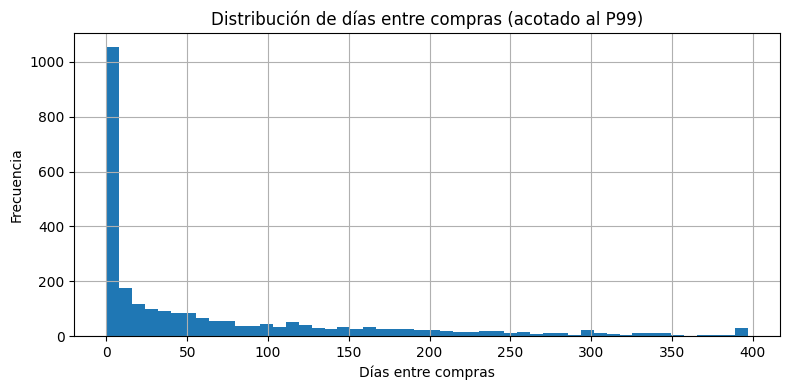

In [8]:
# 8.1 Cálculo de intervalos entre compras por cliente

# Usamos orders_enriched (solo órdenes entregadas hasta FECHA_CORTE)
df_intervals = orders_enriched[['customer_unique_id', 'order_purchase_timestamp']].copy()

# Ordenar por cliente y fecha de compra
df_intervals = df_intervals.sort_values(
    ['customer_unique_id', 'order_purchase_timestamp']
)

# Fecha de la siguiente compra por cliente
df_intervals['next_purchase_timestamp'] = (
    df_intervals
    .groupby('customer_unique_id')['order_purchase_timestamp']
    .shift(-1)
)

# Días entre una compra y la siguiente
df_intervals['days_between_orders'] = (
    df_intervals['next_purchase_timestamp'] - df_intervals['order_purchase_timestamp']
).dt.days

# Nos quedamos solo con intervalos válidos (no nulos y no negativos)
intervals = df_intervals.dropna(subset=['days_between_orders']).copy()
intervals = intervals[intervals['days_between_orders'] >= 0]

# Serie global que usaremos en el siguiente bloque
days_between_orders = intervals['days_between_orders']

n_intervals = len(days_between_orders)
n_clients_multi_orders = intervals['customer_unique_id'].nunique()

print("Resumen de intervalos entre compras (solo clientes con 2+ órdenes):")
print(f"  • Número de intervalos           : {n_intervals:,}")
print(f"  • Clientes con 2+ compras        : {n_clients_multi_orders:,}")

# Estadísticos básicos
q1 = days_between_orders.quantile(0.25)
median = days_between_orders.quantile(0.50)
q3 = days_between_orders.quantile(0.75)
iqr = q3 - q1
p80 = days_between_orders.quantile(0.80)
p90 = days_between_orders.quantile(0.90)
p95 = days_between_orders.quantile(0.95)
p99 = days_between_orders.quantile(0.99)

print("\nEstadísticos de days_between_orders (en días):")
print(f"  Q1 (25%)           : {q1:6.1f}")
print(f"  Mediana (50%)      : {median:6.1f}")
print(f"  Q3 (75%)           : {q3:6.1f}")
print(f"  IQR (Q3 - Q1)      : {iqr:6.1f}")
print(f"  Percentil 80       : {p80:6.1f}")
print(f"  Percentil 90       : {p90:6.1f}")
print(f"  Percentil 95       : {p95:6.1f}")
print(f"  Percentil 99       : {p99:6.1f}")
print(f"  Máximo observado   : {days_between_orders.max():6.1f}")

# Histograma acotado al P99 para evitar la cola muy larga
plt.figure(figsize=(8, 4))
upper = days_between_orders.quantile(0.99)
days_between_orders.clip(upper=upper).hist(bins=50)
plt.title('Distribución de días entre compras (acotado al P99)')
plt.xlabel('Días entre compras')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

## 8.2 Cálculo de umbrales de recencia para pre-churn y churn final

In [9]:
# 8.2) Definición de umbrales de recencia (pre-churn y churn final, 100% data-driven)

print("8.2) Definición de umbrales de recencia (pre-churn y churn final)\n")

# Recalculamos los intervalos entre compras por cliente
df_sorted = orders_enriched.sort_values(
    ["customer_unique_id", "order_purchase_timestamp"]
).copy()

df_sorted["next_purchase"] = df_sorted.groupby("customer_unique_id")[
    "order_purchase_timestamp"
].shift(-1)

df_sorted["days_between_orders"] = (
    df_sorted["next_purchase"] - df_sorted["order_purchase_timestamp"]
).dt.days

intervals = df_sorted["days_between_orders"].dropna()

# Percentiles clave de los intervalos entre compras
p90 = np.percentile(intervals, 90)
p99 = np.percentile(intervals, 99)

CHURN_PRELIM_THRESHOLD = int(round(p90))   # pre-churn
CHURN_FINAL_THRESHOLD = int(round(p99))   # churn final (casos extremos)

print("Umbrales de recencia calculados (en días, usando distribución de intervalos entre compras):")
print(f"  • Pre-churn  (percentil 90) : {CHURN_PRELIM_THRESHOLD} días")
print(f"  • Churn final (percentil 99): {CHURN_FINAL_THRESHOLD} días")

print("\nEstos valores reemplazan a los 90 y 365 fijos; ahora ambos salen de la distribución real de días entre compras.")

8.2) Definición de umbrales de recencia (pre-churn y churn final)

Umbrales de recencia calculados (en días, usando distribución de intervalos entre compras):
  • Pre-churn  (percentil 90) : 214 días
  • Churn final (percentil 99): 397 días

Estos valores reemplazan a los 90 y 365 fijos; ahora ambos salen de la distribución real de días entre compras.


## 9. Definición de target de churn (preliminar y final) + KPIs

In [10]:

# 9. Definición de target de churn (preliminar y final) + KPIs (usando thresholds calculados)

# Aseguramos que los thresholds vienen de la sección 8.2
try:
    CHURN_PRELIM_THRESHOLD
    CHURN_FINAL_THRESHOLD
except NameError:
    raise RuntimeError(
        "CHURN_PRELIM_THRESHOLD / CHURN_FINAL_THRESHOLD no están definidos. "
        "Ejecuta primero las secciones 8.1 y 8.2."
    )

print("Thresholds de recencia utilizados (en días):")
print(f"  • Pre-churn  : {CHURN_PRELIM_THRESHOLD}")
print(f"  • Churn final: {CHURN_FINAL_THRESHOLD}")

# Crear targets en base a recency_days y los umbrales calculados
customer_features['churn_prelim'] = (
    customer_features['recency_days'] > CHURN_PRELIM_THRESHOLD
).astype(int)

customer_features['churn_final'] = (
    customer_features['recency_days'] > CHURN_FINAL_THRESHOLD
).astype(int)

def print_churn_distribution(df_cf: pd.DataFrame, label_col: str):
    """Imprime distribución de una variable binaria de churn."""
    churn_count = df_cf[label_col].sum()
    total = len(df_cf)
    active_count = total - churn_count
    churn_rate = churn_count / total * 100
    print(f"Target: {label_col}")
    print(f"  Clientes totales : {total:6d}")
    print(f"  Churned (1)      : {churn_count:6d} ({churn_rate:5.1f}%)")
    print(f"  Activos  (0)     : {active_count:6d} ({100 - churn_rate:5.1f}%)\n")

print("\nDistribución de targets con umbrales calculados:\n")
print_churn_distribution(customer_features, 'churn_prelim')
print_churn_distribution(customer_features, 'churn_final')

# Target principal para modelado
TARGET_COL = 'churn_final'

def compute_basic_kpis(df_cf: pd.DataFrame, target_col: str) -> dict:
    """KPIs básicos de negocio a nivel cliente."""
    churn_rate = df_cf[target_col].mean()
    retention_rate = 1 - churn_rate
    clientes_totales = len(df_cf)
    clientes_churn = int(df_cf[target_col].sum())
    clientes_activos = int(clientes_totales - clientes_churn)

    avg_monetary = df_cf['order_value_sum'].mean()
    active_monetary = df_cf.loc[df_cf[target_col] == 0, 'order_value_sum'].mean()
    churned_monetary = df_cf.loc[df_cf[target_col] == 1, 'order_value_sum'].mean()

    res = {
        'clientes_totales': clientes_totales,
        'clientes_churn': clientes_churn,
        'clientes_activos': clientes_activos,
        'churn_rate': churn_rate,
        'retention_rate': retention_rate,
        'avg_monetary_total': avg_monetary,
        'avg_monetary_activos': active_monetary,
        'avg_monetary_churn': churned_monetary
    }

    print("KPIs de negocio (con target churn_final):")
    print(f"  • Churn rate      : {churn_rate*100:5.2f}%")
    print(f"  • Retention rate  : {retention_rate*100:5.2f}%")
    print(f"  • Gasto promedio total  : {avg_monetary:,.2f}")
    print(f"  • Gasto promedio activos: {active_monetary:,.2f}")
    print(f"  • Gasto promedio churn  : {churned_monetary:,.2f}")
    return res

kpis_base = compute_basic_kpis(customer_features, TARGET_COL)

Thresholds de recencia utilizados (en días):
  • Pre-churn  : 214
  • Churn final: 397

Distribución de targets con umbrales calculados:

Target: churn_prelim
  Clientes totales :  81147
  Churned (1)      :  35185 ( 43.4%)
  Activos  (0)     :  45962 ( 56.6%)

Target: churn_final
  Clientes totales :  81147
  Churned (1)      :  10070 ( 12.4%)
  Activos  (0)     :  71077 ( 87.6%)

KPIs de negocio (con target churn_final):
  • Churn rate      : 12.41%
  • Retention rate  : 87.59%
  • Gasto promedio total  : 164.98
  • Gasto promedio activos: 164.48
  • Gasto promedio churn  : 168.52


## 10. Preparación de datos y selección de variables

Top 15 correlaciones (|corr|):
  recency_days                       : +0.680 (FUERTE)
  delivery_delay_days_max            : -0.124 (DÉBIL)
  delivery_delay_days_mean           : -0.124 (DÉBIL)
  delivery_delay_days_min            : -0.121 (DÉBIL)
  carrier_to_customer_days_std       : -0.086 (DÉBIL)
  avg_review_score_std               : -0.083 (DÉBIL)
  avg_installments_std               : -0.057 (DÉBIL)
  num_delayed_orders                 : -0.046 (DÉBIL)
  pct_delayed_orders                 : -0.045 (DÉBIL)
  pct_early_orders                   : +0.045 (DÉBIL)
  n_sellers_std                      : -0.041 (DÉBIL)
  approval_to_carrier_days_std       : +0.039 (DÉBIL)
  customer_lifetime_days             : -0.036 (DÉBIL)
  purchase_to_approval_days_std      : -0.035 (DÉBIL)
  avg_days_between_orders            : -0.035 (DÉBIL)


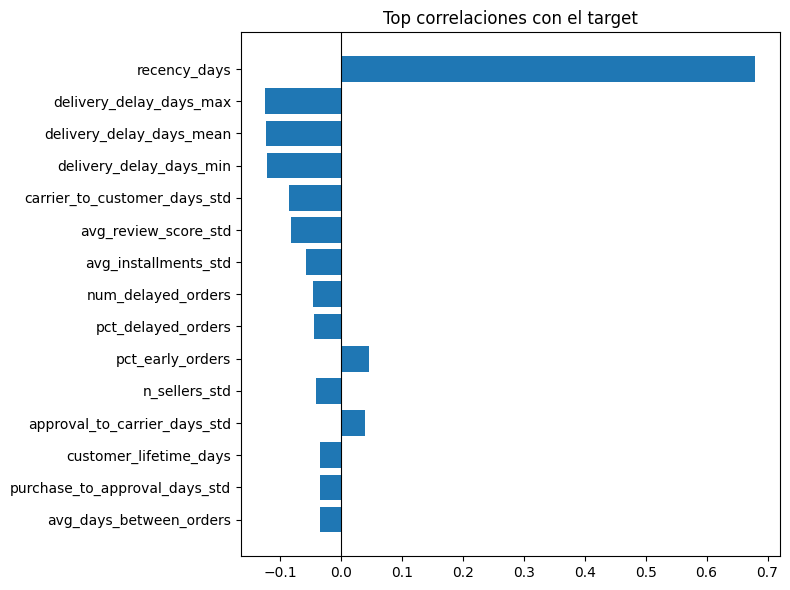

Shape de X, y: (81147, 94) (81147,)
Train / Test listos.


In [11]:

numeric_vars = [
    col for col in customer_features.select_dtypes(include=[np.number]).columns
    if col not in ['churn_prelim', 'churn_final']
]

corr_rows = []
for var in numeric_vars:
    corr = customer_features[[var, TARGET_COL]].corr().iloc[0, 1]
    corr_rows.append({'Variable': var, 'Correlation': corr, 'Abs': abs(corr)})

corr_df = (
    pd.DataFrame(corr_rows)
    .dropna()
    .sort_values('Abs', ascending=False)
)

print("Top 15 correlaciones (|corr|):")
for _, row in corr_df.head(15).iterrows():
    strength = "FUERTE" if abs(row['Correlation']) > 0.5 else                    "MODERADA" if abs(row['Correlation']) > 0.3 else "DÉBIL"
    print(f"  {row['Variable']:35s}: {row['Correlation']:+.3f} ({strength})")

top_corr = corr_df.head(15)
plt.figure(figsize=(8, 6))
plt.barh(top_corr['Variable'], top_corr['Correlation'])
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Top correlaciones con el target')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_cols_numeric = numeric_vars
feature_cols_categ = ['customer_state']

X_num = customer_features[feature_cols_numeric].fillna(0)
X_cat = pd.get_dummies(customer_features[feature_cols_categ], drop_first=True)

X = pd.concat([X_num, X_cat], axis=1)
y = customer_features[TARGET_COL]

print("Shape de X, y:", X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train / Test listos.")


## 11. Modelos (Logistic Regression y Random Forest)

Reporte – Regresión Logística
              precision    recall  f1-score   support

           0      1.000     0.990     0.995     21324
           1      0.931     0.999     0.964      3021

    accuracy                          0.991     24345
   macro avg      0.966     0.994     0.979     24345
weighted avg      0.991     0.991     0.991     24345

ROC-AUC: 0.9999653057000918


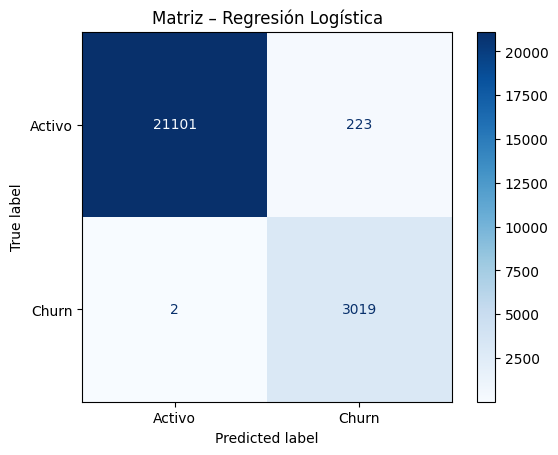

Reporte – Random Forest
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     21324
           1      1.000     1.000     1.000      3021

    accuracy                          1.000     24345
   macro avg      1.000     1.000     1.000     24345
weighted avg      1.000     1.000     1.000     24345

ROC-AUC: 1.0


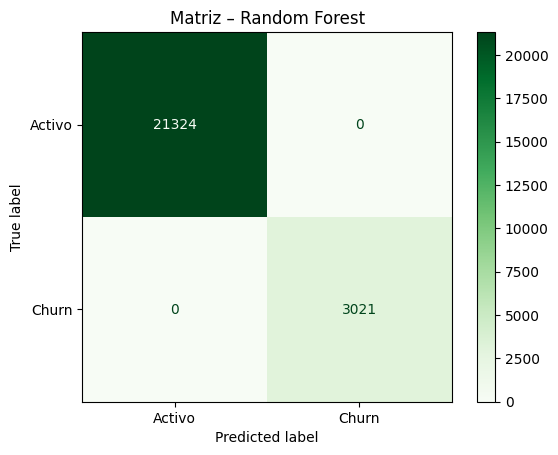


Top 20 variables más importantes (RF):


,importance
recency_days,0.6986
purchase_to_approval_days_mean,0.0315
purchase_to_approval_days_max,0.0306
purchase_to_approval_days_min,0.0290
delivery_delay_days_mean,0.0194
delivery_delay_days_min,0.0191
delivery_delay_days_max,0.0182
total_freight_value_min,0.0112
total_freight_value_max,0.0106
total_freight_value_mean,0.0105


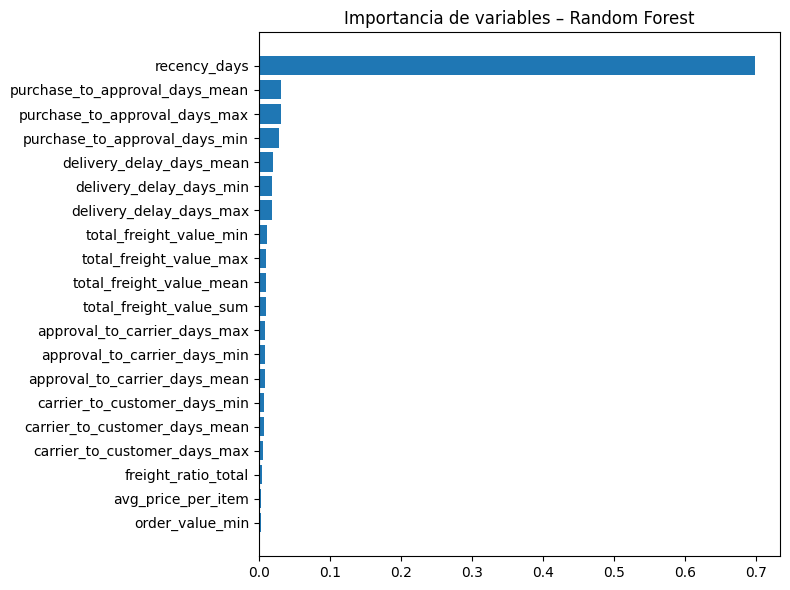

KPIs de modelado: {'roc_auc_lr': np.float64(0.9999653057000918), 'roc_auc_rf': np.float64(1.0)}


In [12]:

# Regresión Logística
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Reporte – Regresión Logística")
print(classification_report(y_test, y_pred_lr, digits=3))
roc_lr = roc_auc_score(y_test, y_proba_lr)
print("ROC-AUC:", roc_lr)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=['Activo', 'Churn'],
    cmap='Blues'
)
plt.title('Matriz – Regresión Logística')
plt.show()

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Reporte – Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))
roc_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC-AUC:", roc_rf)

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf,
    display_labels=['Activo', 'Churn'],
    cmap='Greens'
)
plt.title('Matriz – Random Forest')
plt.show()

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 20 variables más importantes (RF):")
display(importances.head(20).to_frame('importance'))

top_imp = importances.head(20)
plt.figure(figsize=(8, 6))
plt.barh(top_imp.index, top_imp.values)
plt.title('Importancia de variables – Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

kpis_modelado = {
    'roc_auc_lr': roc_lr,
    'roc_auc_rf': roc_rf
}
print("KPIs de modelado:", kpis_modelado)


## 12. Métricas de negocio y pruebas Chi² / ANOVA

In [13]:

X_num = customer_features[numeric_vars].fillna(0)
mm_scaler = MinMaxScaler()
X_chi2 = mm_scaler.fit_transform(X_num)

chi2_vals, chi2_p = chi2(X_chi2, y)
chi2_results = pd.DataFrame({
    'feature': numeric_vars,
    'chi2_stat': chi2_vals,
    'p_value': chi2_p
}).sort_values('p_value')

print("Top 10 variables (Chi²):")
display(chi2_results.head(10))

f_vals, f_p = f_classif(X_num, y)
f_results = pd.DataFrame({
    'feature': numeric_vars,
    'f_stat': f_vals,
    'p_value': f_p
}).sort_values('p_value')

print("\nTop 10 variables (ANOVA F-test):")
display(f_results.head(10))


Top 10 variables (Chi²):


,feature,chi2_stat,p_value
61,recency_days,"5,292.8473",0.0000
64,pct_delayed_orders,148.0472,0.0000
59,num_delayed_orders,53.2903,0.0000
62,customer_lifetime_days,35.1835,0.0000
63,avg_days_between_orders,33.2731,0.0000
37,avg_review_score_std,22.2662,0.0000
65,pct_early_orders,13.2848,0.0003
26,n_sellers_max,10.3978,0.0013
23,n_sellers_mean,9.3635,0.0022
33,avg_installments_std,8.8808,0.0029



Top 10 variables (ANOVA F-test):


,feature,f_stat,p_value
61,recency_days,"69,901.5516",0.0000
58,delivery_delay_days_max,"1,276.3156",0.0000
55,delivery_delay_days_mean,"1,258.3874",0.0000
57,delivery_delay_days_min,"1,212.8870",0.0000
59,num_delayed_orders,172.1225,0.0000
64,pct_delayed_orders,163.4617,0.0000
65,pct_early_orders,162.9710,0.0000
62,customer_lifetime_days,102.4044,0.0000
63,avg_days_between_orders,98.3362,0.0000
49,approval_to_carrier_days_min,76.5362,0.0000


## 13. Función `run_monthly_pipeline()` y persistencia de snapshots

In [14]:

def run_monthly_pipeline(
    periodo_objetivo: str,
    data_raw: dict,
    processed_dir: Path
):
    periodo = pd.Period(periodo_objetivo, freq='M')
    fecha_corte = periodo.to_timestamp('M')
    print(f"=== Pipeline para {periodo_objetivo} (corte {fecha_corte.date()}) ===")

    last_period = get_last_processed_period(processed_dir / 'features')
    if last_period is not None and periodo_objetivo <= last_period:
        raise ValueError(f"Período {periodo_objetivo} ya procesado o anterior ({last_period}).")

    data_cut = cut_data_to_fecha_corte(data_raw, fecha_corte)
    orders_enriched = build_orders_enriched(
        data_cut['orders'],
        data_cut['customers'],
        data_cut['order_items'],
        data_cut['order_payments'],
        data_cut['order_reviews']
    )
    customer_features = build_customer_features(orders_enriched, fecha_corte)

    customer_features['churn_final'] = (
        customer_features['recency_days'] > CHURN_FINAL_THRESHOLD
    ).astype(int)

    kpis = compute_basic_kpis(customer_features, 'churn_final')

    numeric_vars_local = [
        col for col in customer_features.select_dtypes(include=[np.number]).columns
        if col not in ['churn_prelim', 'churn_final']
    ]
    X_num = customer_features[numeric_vars_local].fillna(0)
    X_cat = pd.get_dummies(customer_features[['customer_state']], drop_first=True)
    X_local = pd.concat([X_num, X_cat], axis=1)
    y_local = customer_features['churn_final']

    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
        X_local, y_local, test_size=0.3, random_state=42, stratify=y_local
    )
    scaler_l = StandardScaler()
    X_train_ls = scaler_l.fit_transform(X_train_l)
    X_test_ls = scaler_l.transform(X_test_l)

    lr_l = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_l.fit(X_train_ls, y_train_l)
    roc_lr_l = roc_auc_score(y_test_l, lr_l.predict_proba(X_test_ls)[:, 1])

    rf_l = RandomForestClassifier(
        n_estimators=200, max_depth=None, random_state=42, class_weight='balanced'
    )
    rf_l.fit(X_train_l, y_train_l)
    roc_rf_l = roc_auc_score(y_test_l, rf_l.predict_proba(X_test_l)[:, 1])

    master_path = processed_dir / 'master' / f"orders_enriched_{periodo_objetivo}.parquet"
    features_path = processed_dir / 'features' / f"customer_features_{periodo_objetivo}.parquet"

    orders_enriched.to_parquet(master_path, index=False)
    customer_features.to_parquet(features_path, index=False)

    print("Guardado:")
    print(" -", master_path)
    print(" -", features_path)

    kpis_row = {
        'periodo': periodo_objetivo,
        'fecha_corte': fecha_corte.date(),
        'clientes_totales': kpis['clientes_totales'],
        'clientes_churn': kpis['clientes_churn'],
        'clientes_activos': kpis['clientes_activos'],
        'churn_rate': kpis['churn_rate'],
        'retention_rate': kpis['retention_rate'],
        'avg_monetary_total': kpis['avg_monetary_total'],
        'avg_monetary_activos': kpis['avg_monetary_activos'],
        'avg_monetary_churn': kpis['avg_monetary_churn'],
        'roc_auc_lr': roc_lr_l,
        'roc_auc_rf': roc_rf_l
    }

    metrics_dir = processed_dir / 'metrics'
    kpis_file = metrics_dir / "kpis_churn_history.csv"
    if kpis_file.exists():
        kpis_hist = pd.read_csv(kpis_file)
        kpis_hist = pd.concat([kpis_hist, pd.DataFrame([kpis_row])], ignore_index=True)
    else:
        kpis_hist = pd.DataFrame([kpis_row])
    kpis_hist.to_csv(kpis_file, index=False)
    print("KPIs actualizados en:", kpis_file)

    return {
        'orders_enriched': orders_enriched,
        'customer_features': customer_features,
        'kpis': kpis_row
    }

# Ejecutar el pipeline para el período definido en PERIODO_OBJETIVO
results_periodo = run_monthly_pipeline(PERIODO_OBJETIVO, data, PROCESSED_DIR)

print("\nResumen de KPIs del período:")
for k, v in results_periodo['kpis'].items():
    print(f"  {k}: {v}")


=== Pipeline para 2018-06 (corte 2018-06-30) ===
Número total de variables (columnas): 72
KPIs de negocio (con target churn_final):
  • Churn rate      : 12.41%
  • Retention rate  : 87.59%
  • Gasto promedio total  : 164.98
  • Gasto promedio activos: 164.48
  • Gasto promedio churn  : 168.52
Guardado:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master/orders_enriched_2018-06.parquet
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features/customer_features_2018-06.parquet
KPIs actualizados en: /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics/kpis_churn_history.csv

Resumen de KPIs del período:
  periodo: 2018-06
  fecha_corte: 2018-06-30
  clientes_totales: 81147
  clientes_churn: 10070
  clientes_activos: 71077
  churn_rate: 0.12409577680012816
  retention_rate: 0.8759042231998718
  avg_monetary_total: 164.98419325421764
  avg_monetary_activos: 164.4834530157435
  avg_monetary_churn: 168.51856405163852
  roc_auc_lr: 0.9999653057000918
  roc_auc_rf: 1.0


In [15]:
results_2018_07 = run_monthly_pipeline("2018-07", data, PROCESSED_DIR)

=== Pipeline para 2018-07 (corte 2018-07-31) ===
Número total de variables (columnas): 72
KPIs de negocio (con target churn_final):
  • Churn rate      : 15.15%
  • Retention rate  : 84.85%
  • Gasto promedio total  : 165.48
  • Gasto promedio activos: 165.23
  • Gasto promedio churn  : 166.86
Guardado:
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/master/orders_enriched_2018-07.parquet
 - /content/drive/MyDrive/Maestria/M13/Olist/processed/features/customer_features_2018-07.parquet
KPIs actualizados en: /content/drive/MyDrive/Maestria/M13/Olist/processed/metrics/kpis_churn_history.csv



## 14. Notas para Git y storytelling

- Versionar este notebook en Git junto con:
  - README con descripción del problema, datos y pipeline.
  - Diagrama simple del flujo mensual (ingesta → features → modelo → KPIs).
- Para la exposición (15 minutos):
  - Explicar el **problema de negocio** y el costo del churn.
  - Mostrar **cómo se construyen las features** (RFM, logística, valor).
  - Resumir **target final** y **churn rate**.
  - Presentar **importancia de variables** (RF) y **métricas** (recall, ROC-AUC).
  - Cerrar con cómo el pipeline se puede correr **cada mes** para actualizar alarmas de clientes en riesgo.


## Z. Reset de snapshots del pipeline (borrar resultados previos)

In [16]:
from pathlib import Path

def reset_processed_outputs(processed_dir: Path):
    """Elimina los archivos generados por el pipeline (snapshots), sin tocar los datos crudos."""
    master_dir = processed_dir / 'master'
    features_dir = processed_dir / 'features'
    metrics_dir = processed_dir / 'metrics'

    deleted_master = 0
    deleted_features = 0
    deleted_metrics = 0

    # Borrar Parquet de master
    if master_dir.exists():
        for f in master_dir.glob('*.parquet'):
            f.unlink()
            deleted_master += 1

    # Borrar Parquet de features
    if features_dir.exists():
        for f in features_dir.glob('*.parquet'):
            f.unlink()
            deleted_features += 1

    # Borrar CSV de KPIs
    if metrics_dir.exists():
        for f in metrics_dir.glob('*.csv'):
            f.unlink()
            deleted_metrics += 1

    print("Reset de snapshots completado:")
    print(f"  • Archivos master   eliminados: {deleted_master}")
    print(f"  • Archivos features eliminados: {deleted_features}")
    print(f"  • Archivos metrics  eliminados: {deleted_metrics}")

# Ejecutar reset (OPCIONAL; solo cuando quieras volver a empezar desde cero)
# reset_processed_outputs(PROCESSED_DIR)